
# Example of the `aitlas` toolbox for benchmarking a dataset

This notebook shows a sample implementation of a multi class image classification using the `aitlas` toolbox using the UC Merced dataset.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from aitlas.datasets import UcMercedDataset
from aitlas.models import VGG16
from aitlas.tasks import StratifiedSplitTask

## Define the splits and dataset paths

In [19]:
splits = [(10, 90), (20, 80), (30, 70), (40, 60), (50, 50), (60, 40), (70, 30), 
          (80, 20), (90, 10)] # one tuple is (train, test)
data_dir = "/media/hdd/multi-class/UCMerced" # where is the dataset on disk

## Loop through the splits, train and evaluate

In [ ]:
results = [] # results accumulator

# iterate through the splits
for train, test in splits:
    # where to store the file names of the train images
    train_csv_file = f"/media/hdd/multi-class/UCMerced/train_{train}_{test}.csv"
    # where to store the file names of the test images
    test_csv_file = f"/media/hdd/multi-class/UCMerced/test_{train}_{test}.csv"
    # configure split task
    split_config = {
        "split": {
            "train": {
                "ratio": train,
                "file": train_csv_file
            },
            "test": {
                "ratio": test,
                "file": test_csv_file
            }
        },
        "data_dir": data_dir
    }
    split_task = StratifiedSplitTask(None, split_config)
    split_task.run()
    
    # setup train set
    train_dataset_config = {
        "batch_size": 4,
        "shuffle": True,
        "num_workers": 4,
        "csv_file": train_csv_file,
        "data_dir": data_dir,  
        "transforms": ["aitlas.transforms.ResizeCenterCropFlipHVToTensor"]
    }

    train_dataset = UcMercedDataset(train_dataset_config)
    
    # setup test set
    test_dataset_config = {
        "batch_size": 4,
        "shuffle": False,
        "num_workers": 4,
        "csv_file": test_csv_file,
        "data_dir": data_dir,
        "transforms": ["aitlas.transforms.ResizeCenterCropToTensor"]
    }

    test_dataset = UcMercedDataset(test_dataset_config)
    print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
    
    
    # setup model
    epochs = 50
    model_directory = "./experiments/uc_merced/"
    model_config = {
        "num_classes": 21, 
        "learning_rate": 0.0001,
        "pretrained": True
    }
    model = VGG16(model_config)
    model.prepare()

    # training and evaluation
    model.train_and_evaluate_model(
        train_dataset=train_dataset,
        epochs=epochs,
        model_directory=model_directory,
        val_dataset=test_dataset,
        run_id='1',
    )
    
    # collect results
    results.append(model.running_metrics.f1_score())

## See the results

In [21]:
df = pd.DataFrame(zip(splits, [round(float(r["F1_score Micro"]), 4) for r in results]), 
                  columns=["Train/Test", "Micro F1 score"])
df

,Train/Test,Micro F1 score
0,"(10, 90)",0.7450
1,"(20, 80)",0.7107
2,"(30, 70)",0.8741
3,"(40, 60)",0.8619
4,"(50, 50)",0.9181
5,"(60, 40)",0.8857
6,"(70, 30)",0.9032
7,"(80, 20)",0.8405
8,"(90, 10)",0.9143


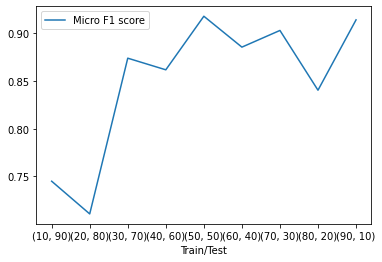

In [22]:
df.plot(x='Train/Test', y='Micro F1 score', kind = 'line')
plt.show()